In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as ss
from sklearn import tree

In [2]:
#load data, in sparse format
def load_data(filename):
    f = open('dorothea/%s.data' % filename)
    I,J = [],[]
    for k in range(100000):
        line = f.readline()
        if len(line) == 0:
            print('done')
            break

        line = [int(x) for x in line.split()]
        J.extend(line)
        I.extend(k for i in range(len(line)))

    return ss.coo_matrix((np.ones(len(I)), (I,J)))


def load_labels(filename):
    f = open('dorothea/%s.labels' % filename)
    y = []
    for k in range(100000):
        line = f.readline()
        
        if len(line) == 0:
            print('done')
            break
        y.append(int(line))
    return np.array(y)


Xtrain = load_data('dorothea_train')
ytrain = load_labels('dorothea_train')

Xtest= load_data('dorothea_valid')
ytest = load_labels('dorothea_valid')

print( Xtrain.shape,  Xtest.shape, Xtrain.nnz)

done
done
done
done
(800, 100001) (350, 100001) 727760


In [3]:


print (Xtrain)

  (0, 191)	1.0
  (0, 367)	1.0
  (0, 614)	1.0
  (0, 634)	1.0
  (0, 711)	1.0
  (0, 1202)	1.0
  (0, 1220)	1.0
  (0, 1311)	1.0
  (0, 1472)	1.0
  (0, 1730)	1.0
  (0, 2281)	1.0
  (0, 2572)	1.0
  (0, 2602)	1.0
  (0, 2611)	1.0
  (0, 2824)	1.0
  (0, 2855)	1.0
  (0, 2940)	1.0
  (0, 3149)	1.0
  (0, 3313)	1.0
  (0, 3560)	1.0
  (0, 3568)	1.0
  (0, 3824)	1.0
  (0, 4185)	1.0
  (0, 4266)	1.0
  (0, 4366)	1.0
  :	:
  (799, 97876)	1.0
  (799, 97899)	1.0
  (799, 98032)	1.0
  (799, 98266)	1.0
  (799, 98277)	1.0
  (799, 98301)	1.0
  (799, 98342)	1.0
  (799, 98353)	1.0
  (799, 98413)	1.0
  (799, 98419)	1.0
  (799, 98448)	1.0
  (799, 98458)	1.0
  (799, 98468)	1.0
  (799, 98635)	1.0
  (799, 98892)	1.0
  (799, 99118)	1.0
  (799, 99337)	1.0
  (799, 99621)	1.0
  (799, 99625)	1.0
  (799, 99739)	1.0
  (799, 99745)	1.0
  (799, 99755)	1.0
  (799, 99828)	1.0
  (799, 99955)	1.0
  (799, 99967)	1.0


In [4]:
def get_class_balance(y):
    numOfPos = 0
    numOfNeg = 0
    for label in y:
        if label == 1:
            numOfPos+=1
        elif label == -1:
            numOfNeg+=1
    return numOfPos, numOfNeg

print ('class balance is currently %.2f  +1, %.2f -1' % get_class_balance(ytrain))

class balance is currently 78.00  +1, 722.00 -1


In [5]:
def get_misclass(y,yhat):
    #went over in class a cheat way to calc misclass rate
    return np.mean(np.not_equal(y, yhat))


def get_f1(y,yhat):
    detectedCounter = 0
    retrievedCounter = 0
    relevantCounter = 0
    
    for i in range(len(y)):
        if y[i] == 1 and yhat[i] == 1:
            detectedCounter+=1
        if yhat[i] == 1:
            retrievedCounter+=1
        if y[i] == 1:
            relevantCounter+=1
            
    P = detectedCounter / retrievedCounter
    R = detectedCounter / relevantCounter

        
    return (2*P*R) / (P + R)

depth = 3
clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth, class_weight='balanced')
clf = clf.fit(Xtrain, ytrain)

print( get_misclass(ytrain, clf.predict(Xtrain) ), get_f1(ytrain, clf.predict(Xtrain) )) #training
print (get_misclass(ytest, clf.predict(Xtest) ), get_f1(ytest, clf.predict(Xtest) ))     #testing

0.04125 0.7724137931034484
0.07142857142857142 0.6031746031746031


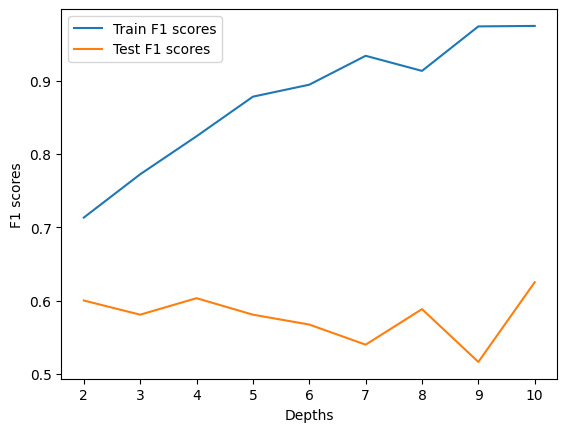

In [6]:
#no cross validation

depths = [2,3,4,5,6,7,8,9,10]
trainScores = []
testScores = []

for i in depths:
    clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=i, class_weight='balanced')
    clf = clf.fit(Xtrain, ytrain)
    trainScores.append(get_f1(ytrain, clf.predict(Xtrain)))
    testScores.append(get_f1(ytest, clf.predict(Xtest)))

plt.plot(depths, trainScores, label="Train F1 scores")
plt.plot(depths, testScores, label="Test F1 scores")
plt.xlabel('Depths')
plt.ylabel('F1 scores')
plt.legend()
plt.show()                                              

In [7]:
#convert coo.coo matrix to usable numpy array
Xtrain = Xtrain.todense()
Xtrain = np.asarray(Xtrain)

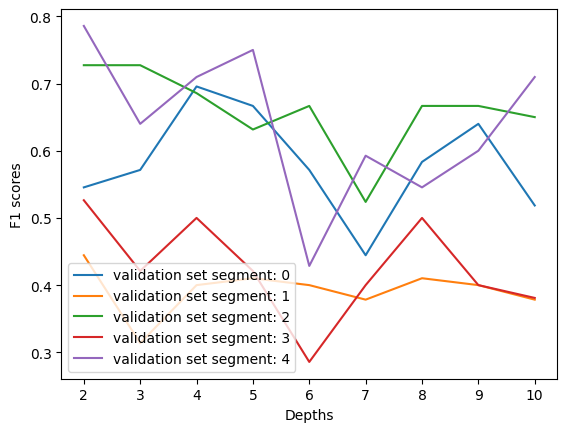

In [8]:
# k-fold cross validation for K = 5

K = 5
XtrainSegments = []
YtrainSegments = []

depths = [2,3,4,5,6,7,8,9,10]



lengthOfPartition = Xtrain.shape[0] / K
#0, 1, 2, 3, 4
for i in range(K):
    XtrainSegments.append(Xtrain[i*160:(i+1)*160])
    YtrainSegments.append(ytrain[i*160:(i+1)*160])
    
#1,...,K
for i in range(K):
    kfoldF1Scores = []

    for j in depths:
        
        XtrainSegCopy = XtrainSegments
        XtrainValidationSet = XtrainSegCopy[i]
        XtrainSegCopy = np.delete(XtrainSegCopy, i, axis=0)
        XtrainRemainingSet = XtrainSegCopy
        XtrainRemainingSet = np.concatenate(XtrainRemainingSet)

        YtrainSegCopy = YtrainSegments
        YtrainValidationSet = YtrainSegCopy[i]
        YtrainSegCopy = np.delete(YtrainSegCopy, i, axis=0)
        YtrainRemainingSet = YtrainSegCopy
        YtrainRemainingSet = np.concatenate(YtrainRemainingSet)
        
        clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=j, class_weight='balanced')
        clf = clf.fit(XtrainRemainingSet, YtrainRemainingSet)
        kfoldF1Scores.append(get_f1(YtrainValidationSet, clf.predict(XtrainValidationSet)))
        
    plt.plot(range(2,11), kfoldF1Scores, label='validation set segment: '+str(i))
    
plt.xlabel('Depths')
plt.ylabel('F1 scores')
plt.legend()
plt.show()


In [9]:
depths = [2,3,4,5,6,7,8,9,10]

outerF1trainScores = []
outerF1testScores = []



for j in depths:
    innerF1trainScores = []
    innerF1testScores = []

    for i in range(K):
        
        XtrainSegCopy = XtrainSegments
        XtrainValidationSet = XtrainSegCopy[i]
        XtrainSegCopy = np.delete(XtrainSegCopy, i, axis=0)
        XtrainRemainingSet = XtrainSegCopy
        XtrainRemainingSet = np.concatenate(XtrainRemainingSet)

        YtrainSegCopy = YtrainSegments
        YtrainValidationSet = YtrainSegCopy[i]
        YtrainSegCopy = np.delete(YtrainSegCopy, i, axis=0)
        YtrainRemainingSet = YtrainSegCopy
        YtrainRemainingSet = np.concatenate(YtrainRemainingSet)
        
        clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=j, class_weight='balanced')
        clf = clf.fit(XtrainRemainingSet, YtrainRemainingSet)
        
        innerF1trainScores.append(get_f1(YtrainValidationSet, clf.predict(XtrainValidationSet)))
        innerF1testScores.append(get_f1(ytest, clf.predict(Xtest)))
    
    outerF1trainScores.append(innerF1trainScores)
    outerF1testScores.append(innerF1testScores)

F1trainAverage = []
F1testAverage = []
for innerArray in outerF1trainScores:
    total = 0
    for innerInnerVal in innerArray:
        total += innerInnerVal
    F1trainAverage.append(total/len(innerArray))
    
for innerArray in outerF1testScores:
    total = 0
    for innerInnerVal in innerArray:
        total += innerInnerVal
    F1testAverage.append(total/len(innerArray))


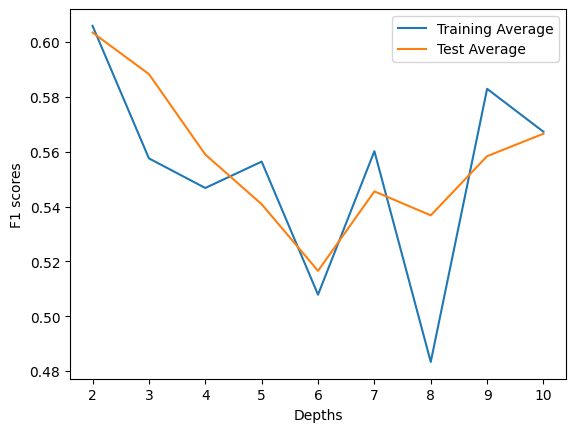

In [10]:
plt.plot(range(2,11), F1trainAverage, label="Training Average")
plt.plot(range(2,11), F1testAverage, label="Test Average")
plt.xlabel('Depths')
plt.ylabel('F1 scores')
plt.legend()
plt.show()